<a href="https://colab.research.google.com/github/Scilent0r/Colabs/blob/master/H2O_SentimentReviewerApp_GoogleDrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# H2O Sentiment analysis

Firstly install and import needed libraries

In [0]:
!pip install h2o
!pip install pydrive
# GoogleDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# H2o
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# Fetch csv-trainingfile from google. 


The one used by me in this example is like this: 

*   "0","my whole body feels itchy and like its on fire"
*   "0","@Kwesidei not the whole crew "
*   "0","Need a hug "

AKA. "int","str"

In [0]:
# Auth to Google
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Download file
download = drive.CreateFile({'id': '1ZYpwdAolJ4tXMAGOT0mkLiqwgXvaOAfA'})
download.GetContentFile('100-prod.csv')

Init new H2O cluster with xG mem size

In [24]:
h2o.init(max_mem_size="2G")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.3" 2019-04-16; OpenJDK Runtime Environment (build 11.0.3+7-Ubuntu-1ubuntu218.04.1); OpenJDK 64-Bit Server VM (build 11.0.3+7-Ubuntu-1ubuntu218.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp7g85uawf
  JVM stdout: /tmp/tmp7g85uawf/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp7g85uawf/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.2
H2O cluster version age:,13 days
H2O cluster name:,H2O_from_python_unknownUser_pqyp5d
H2O cluster total nodes:,1
H2O cluster free memory:,2 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


Visualize with Pandas, if OK put it into h2o Frame

In [26]:
import pandas as pd
import numpy as np

tsv_file="/content/100-prod.csv"
csv_table=pd.read_csv(tsv_file, encoding="ISO-8859-1", header=None, names = ["Response", "Review"])
#csv_table.to_csv('reviews.csv',index=False)

print(type(csv_table))
csv_table
reviews = h2o.h2o.H2OFrame(csv_table)

reviews

<class 'pandas.core.frame.DataFrame'>
Parse progress: |█████████████████████████████████████████████████████████| 100%


Response,Review
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it."
0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
0,my whole body feels itchy and like its on fire
0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
0,@Kwesidei not the whole crew
0,Need a hug
0,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
0,@Tatiana_K nope they didn't have it
0,@twittera que me muera ?


Count each response

In [27]:
reviews["Response"].table()

Response,Count
0,99782
4,99837


Stopwords (if needed)

In [0]:
STOP_WORDS = ["ax","i","you","edu","s","t","m","subject","can","lines","re","what",
               "there","all","we","one","the","a","an","of","or","in","for","by","on",
               "but","is","in","a","not","with","as","was","if","they","are","this","and","it","have",
               "from","at","my","be","by","not","that","to","from","com","org","like","likes","so"]

Tokenize the words

In [0]:

def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [0]:
words = tokenize(reviews["Review"])


In [0]:
#words.head()


Init words2vectors model, vectorize words and define training frame

In [31]:
from h2o.estimators.word2vec import H2OWord2vecEstimator


w2v_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v.hex")
w2v_model.train(training_frame=words)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


Check important synonyms built by the w2v model

In [64]:
#w2v_model.find_synonyms("good", count = 5)
#w2v_model.find_synonyms("bad", count = 5)
#w2v_model.find_synonyms("wet", count = 5)
w2v_model.find_synonyms("cold", count = 5)

OrderedDict([('gloomy', 0.7362135052680969),
             ('foggy', 0.7273847460746765),
             ('chilly', 0.7221243381500244),
             ('windy', 0.7189762592315674),
             ('freezing', 0.7175003886222839)])

***aggregate_method***

Specifies how to aggregate sequences of words. If method is `NONE` then no aggregation is performed and each input word is mapped to a single word-vector. If method is 'AVERAGE' then input is treated as sequences of words delimited by NA. Each word of a sequences is internally mapped to a vector and vectors belonging to the same sentence are averaged and returned in the result.

In [0]:
review_vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")


Takes a sequence of H2O data sets and combines them by column

In [34]:
ext_reviews = reviews.cbind(review_vecs)
ext_reviews

Response,Review,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it.",0.0324234,0.184345,-0.0964382,0.0808914,-0.0561715,-0.0224877,-0.202611,-0.0543058,-0.08933,-0.264029,-0.0232042,-0.0876358,0.0414412,0.0335294,-0.279429,0.0544859,0.15601,0.0985093,0.0153787,-0.0763027,-0.0280057,-0.264764,-0.0887908,-0.144672,0.196332,-0.171364,0.171488,-0.2652,-0.0666428,0.0367933,0.0622416,0.0794091,0.0469039,-0.0493582,0.0259381,0.0544417,-0.0841391,-0.113783,-0.00680823,0.0149049,-0.0350808,-0.103391,0.119465,-0.007128,0.0680333,-0.221496,-0.0257603,0.0958498,0.131913,-0.096104,0.0621594,-0.0261155,0.0926609,-0.207674,-0.0164314,0.0286574,-0.0428146,0.0909299,-0.0879975,0.129961,0.0288002,0.030534,0.136042,-0.0303538,0.0797843,-0.0119439,0.0135192,0.246947,-0.135681,0.113833,0.0135122,-0.117948,0.15983,0.108353,-0.127675,-0.0588442,0.0402749,0.0749673,-0.114044,0.0165229,0.11372,0.00106934,0.01886,-0.132198,-0.217168,-0.0619188,0.0481979,0.199629,0.0166934,0.130693,0.0122104,0.0125202,0.246927,-0.0553483,0.0203096,-0.00987175,-0.0910175,-0.0562764,0.0738815,-0.192332
0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,0.119114,0.161993,-0.0263409,-0.107723,-0.16317,0.0471828,-0.186893,0.0239567,0.122171,-0.357441,0.0575543,0.0952125,0.157636,0.0548376,-0.240399,0.0750619,0.0107581,0.213059,0.0273526,0.121257,-0.0488148,-0.0664499,-0.0725868,-0.121801,0.00146178,-0.237202,0.146526,-0.166679,-0.0141501,0.0521562,0.0649125,0.0919125,0.0375505,-0.0474481,0.0820657,0.0222141,-0.251481,-0.062971,0.0519977,-0.0479504,-0.110399,-0.0276384,0.0454698,-0.000803937,-0.00442633,-0.0908725,0.037216,0.137363,0.0383299,0.0194899,0.000950841,0.0417452,0.105591,-0.184577,0.0596545,0.140071,0.00320146,0.0417772,-0.0137826,0.0543103,-0.0712367,-0.0939116,0.162942,-0.0202627,0.056214,-0.0168887,0.162638,0.110334,-0.27516,0.137843,-0.0465623,-0.140487,0.203225,-0.0429977,-0.0463258,-0.0799231,-0.0497657,0.160697,-0.147197,0.0488978,0.0634878,-0.0488115,0.0567719,-0.142683,-0.104094,0.158126,0.0526414,0.102404,-0.0121396,0.117546,-0.184122,0.042477,0.106106,0.0345667,-0.0398257,-0.0622481,-0.0494423,-0.054147,-0.0431566,-0.118416
0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,0.0910916,0.0941506,0.018561,-0.0178202,-0.174152,-0.118347,-0.373247,0.0996095,-0.0340383,-0.342132,-0.126374,0.0535202,-0.0458001,0.131227,-0.0941253,-0.144591,-0.0260202,0.15404,-0.000677497,-0.0161139,-0.0983184,-0.218332,-0.0834315,-0.125607,-0.0852409,-0.0458936,0.158326,-0.198047,0.000157678,0.0678108,0.155009,0.109046,0.0193892,0.0104393,0.0231547,0.131184,-0.238396,0.0980526,0.06021,-0.0373987,-0.125042,0.0204672,0.155127,0.00267343,0.236948,-0.203143,0.00554999,0.167547,0.109699,-0.060998,-0.00892654,0.00110464,0.123873,-0.180286,0.0563306,0.0512842,0.158445,0.0742445,-0.103635,0.0811274,-0.157933,0.00358202,0.103291,-0.15665,0.0513484,0.0317169,0.0316254,0.162846,-0.320991,0.1006,0.129322,-5.62482e-05,0.0340361,0.00560572,-0.0470827,0.0420372,-0.0510198,-0.0635523,-0.0192683,0.155756,-0.0646623,-0.169778,0.0525737,0.0610069,-0.35324,-0.070855,-0.0868653,0.118048,-0.0759614,0.227266,0.0463384,0.0940016,0.0175858,0.0865577,-0.114933,0.0825462,-0.0503872,-0.012769,0.0247659,-0.101668
0,my whole body feels itchy and like its on fire,0.0322413,0.180657,-0.189659,-0.00669984,-0.104724,0.0601945,-0.398475,0.200432,0.146962,-0.397333,0.222722,0.0671204,0.114398,0.0672257,-0.109625,0.0541644,0.173416,0.328845,0.181594,0.0892694,0.095980

Split to train and test sets

In [0]:
data_split = ext_reviews.split_frame(ratios=[0.8])

ext_train = data_split[0]
ext_test = data_split[1]

#obsolete?

**Build GBM-model**

Gradient Boosting Machine (for Regression and Classification) is a forward learning ensemble method. The guiding heuristic is that good predictive results can be obtained through increasingly refined approximations. H2O’s GBM sequentially builds regression trees on all the features of the dataset in a fully distributed way - each tree is built in parallel.

In [36]:
print("Build a basic GBM model")
gbm_model = H2OGradientBoostingEstimator()
gbm_model.train(x = ext_reviews.names,
                y="Response", 
                training_frame = data_split[0], 
                validation_frame = data_split[1])

Build a basic GBM model
gbm Model Build progress: |███████████████████████████████████████████████| 100%


Build predictor

In [0]:
def predict(job_title,w2v, gbm):
    words = tokenize(h2o.H2OFrame(job_title).ascharacter())
    job_title_vec = w2v.transform(words, aggregate_method="AVERAGE")
    print(gbm.predict(test_data=job_title_vec))

Run predictions

In [58]:
print(predict(["a huge selection"], w2v_model, gbm_model))
print(predict(["RIP in pepperonis"], w2v_model, gbm_model))
print(predict(["very nice idea"], w2v_model, gbm_model))
print(predict(["i am so sad about this"], w2v_model, gbm_model))


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


predict
0.338238



None


Check variable importance: 

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/variable-importance.html

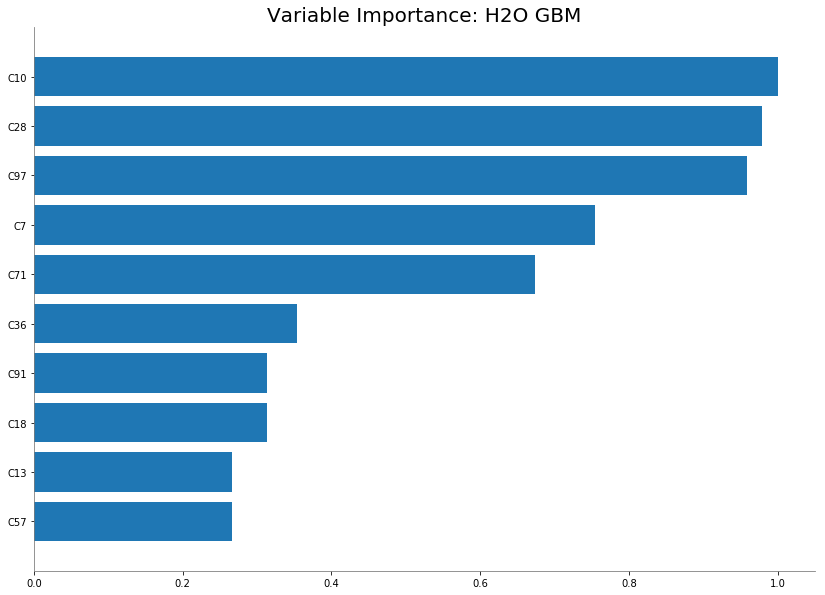

In [39]:
plt=gbm_model.varimp_plot()


**In case you want to save your model:**

*model_path = h2o.save_model(model=gbm_model, path="/content", force=True)*
*print(model_path)*

**In case you want to load your model:**

*saved_model = h2o.load_model(path="/content/GBM_model_python_1565343002584_1")*
*print(saved_model)*